In [1]:
import uproot
import awkward as ak
import numpy as np
import math
from tqdm import tqdm
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
from itertools import product
import sys
sys.path.append('..')  
from Plot import Plot

vector.register_awkward() 
DATATYPE="data"
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data"
SAMPLE_RUN = [291694]#, 290254, 290427, 290613, 290776, 291002, 291360, 291482, 291755, 292061]
MUON_MASS = 0.105
D_ABS = 500

if DATATYPE=="mc":
    gen_tree = f"{BASEDIR}/run{SAMPLE_RUN}.{DATATYPE}.root:genTree"
IS_MC=True if DATATYPE=="mc" else False
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [2]:
def getTracks(events):
    return ak.zip({ "px":events["Muon_Px"],
                    "py":events["Muon_Py"],
                    "pz":events["Muon_Pz"],
                    "E":events["Muon_E"],
                    "DCAx":events["Muon_xDCA"],
                    "DCAy":events["Muon_yDCA"],
                    "DCAz":events["Muon_zDCA"],
                    "charge":events["Muon_Charge"],
                    "thetaAbs":events["Muon_thetaAbs"],
                    "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [3]:
def applySelection(data, criteria, plot=False, **kwargs):
    selected = data[criteria(data)]
    if plot:
        hist_before = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        hist_after = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        try:
            hist_before.fill(ak.flatten(data.pt))
            hist_after.fill(ak.flatten(selected.pt))
        except AttributeError:
            hist_before.fill(ak.flatten(getTracks(data).pt))
            hist_after.fill(ak.flatten(getTracks(selected).pt))
        #Plot(hist_before, hist_after, **kwargs)
    return selected

In [4]:
def get_pDCA_infos(goodTracks):
    DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
    p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
    pDCA=p0*DCA
    
    N=3 #choice of resolution should be a number between 1 and 10
    sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
    pRes= 0.0004 * goodTracks.p
    sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))

    thetaRes= 0.0005 * goodTracks.p
    sigmatheta= 535 * thetaRes

    #computing total resolution for pDCA
    sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

    goodTracks["pDCA"] = pDCA

    return pDCA, N, sigmapDCA

In [5]:
vhMagRaw = hist.Hist(hist.axis.Regular(bins=1000, start=0, stop=5, name='$|p|$'))
def analyzeEventsTree():
    events = uproot.concatenate([data_file_path(SAMPLE) for SAMPLE in SAMPLE_RUN])
    
    # Définition des fonctions de sélection
    def select_charge(events):
        charge = []
        for charges in events["Muon_Charge"]:
            if (-1 in charges) and (1 in charges):
                charge += [True]
            else:
                charge += [False]
        return charge
    
    def select_z(events):
        z = events["zVtx"]
        return (z < 10) & (z > -10)
    
    select_nb = lambda events: events["nMuons"] >= 2
    
    # Sélections pour les tracks
    select_pt = lambda tracks: tracks.pt > 1
    select_match = lambda tracks: tracks.matched >= 1
    select_eta = lambda tracks: (tracks.eta < -2.5) & (tracks.eta > -4)
    select_Rabs = lambda tracks: (D_ABS * np.abs(np.tan(tracks.thetaAbs * (3.141592/180))) > 17.5) & (D_ABS * np.abs(np.tan(tracks.thetaAbs*(3.141592/180))) < 89.5)
    
    # Fonction pour calculer la masse invariante SANS condition sur pDCA
    def calculate_invariant_mass(seltracks, use_y=False):
        invariant_mass = []
        with tqdm(total=len(seltracks.to_list()), desc="Calculating...", bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}') as bar:
            for i, eventTracks in enumerate(seltracks):
                bar.update(1)
                if len(eventTracks) < 2: 
                    continue
                #print(i)
                #print(seltracks[18].to_list())
                #print(seltracks[20].to_list())
                
    
                
                positive = eventTracks[eventTracks.charge == 1]
                negative = eventTracks[eventTracks.charge == -1]
                
                matched = []
                matched = []
                
                for idx_p, p in enumerate(positive):
                    for idx_n, n in enumerate(negative):
                        if idx_p in matched or idx_n in matched: 
                            continue
                        
                        # Condition sur pDCA uniquement si demandé ET si le champ existe
                        y = 0.5*np.log((p.E+n.E + p.pz+n.pz)/(p.E+n.E - p.pz-n.pz))
                        
                        if use_y:
                            if y>-4 and y<-2.5:
                                invariant_mass.append(np.sqrt(2*0.105*0.105 + 2*p.dot(n)))
                                matched.append(idx_p)
                                matched.append(idx_n)
                        else:
                            invariant_mass.append(np.sqrt(2*0.105*0.105 + 2*p.dot(n)))
                            matched.append(idx_p)
                            matched.append(idx_n)
        return invariant_mass
    
    # === SÉLECTIONS SUR LES EVENTS ===
    print("Sélection nMuons >= 2...")
    goodEvents = applySelection(events, select_nb, plot=False)
    
    print("Sélection zVtx...")
    goodEvents = applySelection(goodEvents, select_z, plot=False)
    
    print("Sélection charge...")
    goodEvents = applySelection(goodEvents, select_charge, plot=False)
    
    # === SÉLECTIONS SUR LES TRACKS ===
    tracks = getTracks(goodEvents)
    
    # 1. Coupure pT
    print("\n=== Coupure pT ===")
    tracks_pt = applySelection(tracks, select_pt, plot=False, title=r"$p_T$ selection")
    """
    mass_pt = calculate_invariant_mass(tracks_pt, use_y=False)
    hist_pt = hist.Hist(hist.axis.Regular(bins=1000, start=0, stop=5, name='$|p|$'))
    hist_pt.fill(mass_pt)
    Plot(hist_pt, title="Masse invariante - Coupure pT > 1 GeV", save=True)
    del mass_pt, hist_pt
    gc.collect().
    """
    
    # 2. Coupure pT + match
    print("\n=== Coupure pT + match ===")
    tracks_match = applySelection(tracks_pt, select_match, plot=False, title="match selection")
    """
    mass_match = calculate_invariant_mass(tracks_match, use_y=False)
    hist_match = hist.Hist(hist.axis.Regular(bins=1000, start=0, stop=5, name='$|p|$'))
    hist_match.fill(mass_match)
    Plot(hist_match, title="Masse invariante - Coupures pT + match", save=True)
    del mass_match, hist_match
    gc.collect()
    """
    
    # 3. Coupure pT + match + eta
    print("\n=== Coupure pT + match + eta ===")
    tracks_eta = applySelection(tracks_match, select_eta, plot=False, title=r"$\eta$ selection")
    """
    mass_eta = calculate_invariant_mass(tracks_eta, use_y=False)
    hist_eta = hist.Hist(hist.axis.Regular(bins=1000, start=0, stop=5, name='$|p|$'))
    hist_eta.fill(mass_eta)
    Plot(hist_eta, title=r"Masse invariante - Coupures pT + match + $\eta$", save=True)
    del mass_eta, hist_eta
    gc.collect()
    """
    
    # 4. Coupure pT + match + eta + Rabs
    print("\n=== Coupure pT + match + eta + Rabs ===")
    tracks_Rabs = applySelection(tracks_eta, select_Rabs, plot=False, title=r"$R_abs$ selection")
    """
    mass_Rabs = calculate_invariant_mass(tracks_Rabs, use_y=False)
    hist_Rabs = hist.Hist(hist.axis.Regular(bins=1000, start=0, stop=5, name='$|p|$'))
    hist_Rabs.fill(mass_Rabs)
    Plot(hist_Rabs, title=r"Masse invariante - Coupures pT + match + $\eta$ + $R_{abs}$", save=True)
    del mass_Rabs, hist_Rabs
    gc.collect()
    """
    
    # 5. Coupures (pT + match + eta + Rabs + pDCA)
    print("\n=== Coupure pT + match + eta + Rabs + pDCA (single muons) ===")
    
    pDCA, N, sigmapDCA = get_pDCA_infos(tracks_Rabs)
    select_pDCA = lambda tracks: pDCA < N*sigmapDCA
    goodTracks = applySelection(tracks_Rabs, select_pDCA, plot=False, title="pDCA selection")
    """
    mass_pDCA_single = calculate_invariant_mass(goodTracks, use_y=False)
    vhMagRaw.fill(mass_pDCA_single)
    Plot(vhMagRaw, title="Masse invariante - Coupures pT + match + $\eta$ + $R_{abs}$ + pDCA (single)", save=True)
    """


    # 6. TOUTES les coupures (pT + match + eta + Rabs + pDCA)
    print("\n=== Coupure pT + match + eta + Rabs + pDCA (single muons) + y (pairs)===")
    mass_final = calculate_invariant_mass(goodTracks, use_y=True)
    vhMagRaw.fill(mass_final)
    inv_mass = mass_final
    Plot(vhMagRaw, title="Masse invariante - TOUTES les coupures", save=True)
    
    # Nettoyage final
    del events, goodEvents, tracks, tracks_pt, tracks_match, tracks_eta, tracks_Rabs, goodTracks, mass_final
    gc.collect()
    
    print("\n✓ Analyse terminée !")

    return inv_mass, vhMagRaw

<>:106: SyntaxWarning: invalid escape sequence '\e'
<>:118: SyntaxWarning: invalid escape sequence '\e'
<>:133: SyntaxWarning: invalid escape sequence '\e'
<>:106: SyntaxWarning: invalid escape sequence '\e'
<>:118: SyntaxWarning: invalid escape sequence '\e'
<>:133: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_4647/629242370.py:106: SyntaxWarning: invalid escape sequence '\e'
  """
/tmp/ipykernel_4647/629242370.py:118: SyntaxWarning: invalid escape sequence '\e'
  """
/tmp/ipykernel_4647/629242370.py:133: SyntaxWarning: invalid escape sequence '\e'
  """


{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'data'} .root
Sélection nMuons >= 2...
Sélection zVtx...
Sélection charge...

=== Coupure pT ===

=== Coupure pT + match ===

=== Coupure pT + match + eta ===

=== Coupure pT + match + eta + Rabs ===

=== Coupure pT + match + eta + Rabs + pDCA (single muons) ===

=== Coupure pT + match + eta + Rabs + pDCA (single muons) + y (pairs)===


Calculating...: 100%|██████████████████████████████| 77883/77883 [00:33<00:00, 2348.06it/s]


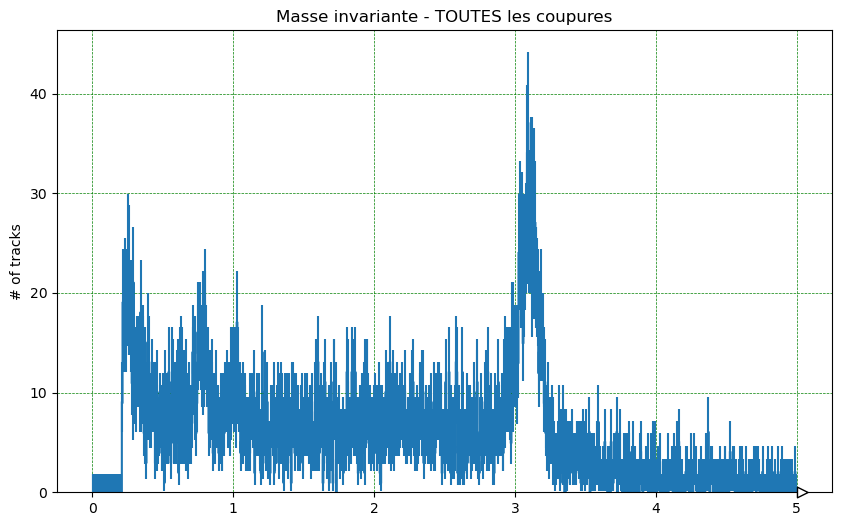


✓ Analyse terminée !


In [6]:
inv_mass_value, inv_mass = analyzeEventsTree()

# Fitting
## Using Roofit let's fit the background noise to extract $N_{J/\psi}$

In [51]:
import ROOT as R

# Create observables
x = R.RooRealVar("x", "x", 0.0, 5.0)

# Construct signal pdf
mean = R.RooRealVar('mean', '', 3.1, 1.5, 5)
sigma = R.RooRealVar('sigma', '', 0.07, 0, 10)
alpha_1 = R.RooRealVar('alpha1', '', 0.8, 0, 5)
n_1 = R.RooRealVar('n1', '', 1.8, 1, 10)
alpha_2 = R.RooRealVar('alpha2', '', 1.5, 0, 5)
n_2 = R.RooRealVar('n2', '', 2.5, 1, 10)

cbs = R.RooCrystalBall("CrystallBall", "CrystallBall", x, mean, sigma, alpha_1, n_1, alpha_2, n_2)
a0 = R.RooRealVar("a0", "a0", 50, 0, 100)
a1 = R.RooRealVar("a1", "a1", -12 -30, 1)
tau = R.RooRealVar("tau", "tau", -0.85, -10, -0.1);
bkg = R.RooExponential("bkg", "bkg", x, tau);
bkgfrac = R.RooRealVar("bkgfrac", "fraction of background", 0.55, 0, 1)

model = R.RooAddPdf("model", "g+a", [bkg, cbs], bkgfrac)

x.setBins(100)

#print(inv_mass)
bins, edges=inv_mass.to_numpy()
print(bins,edges)



#data=R.RooDataSet.from_numpy({'x':np.array(inv_mass)},[x])
data=R.RooDataHist.from_numpy(variables = [x], bins=[len(edges)-1], hist_weights=[bins], ranges=[(edges[0],edges[-1])])
xframe = x.frame(Title="J/psi pdf") 
#print(inv_mass)
#print(np.min(inv_mass))
data.plotOn(xframe)
#cbs.plotOn(xframe)


"""
model.fitTo(data, PrintLevel=-1)

cbs.fitTo(data, PrintLevel=-1)
"""
nll = model.createNLL(data)
m = R.RooMinimizer(nll)
m.setVerbose(True)
m.migrad()
model.getParameters({x}).Print("s")
m.setVerbose(False)

model.plotOn(xframe, Components={bkg}, LineStyle="--")
model.plotOn(xframe, Components={cbs}, LineStyle=":")
model.plotOn(xframe)

can = R.TCanvas()

xframe.Draw()

can.SaveAs("blind_test_ranges.pdf")


"""
sig = R.RooAddPdf('sig', '', R.RooArgList(cbs_1, cbs_2), R.RooArgList(mc_frac))
sig_yield = R.RooRealVar('sig_yield', '', 1794.4, 0, 100000)



exp = R.RooRealVar('exp', '', -2e-3, -4e-3, -0.01e-3)
combinatorial = R.RooExponential('combinatorial', '', x, exp)
bkg_yield = R.RooRealVar('bkg_yield', '', bkg, 0, werte)


pdf_cbWithExp = R.RooAddPdf(
    'pdf_cbWithExp',
    '',
    R.RooArgList(sig, combinatorial),
    R.RooArgList(sig_yield, bkg_yield)
)



data = R.RooDataSet(pdf_cbWithExp.generate(R.RooArgSet(x), werte))
data_red = data.reduce("x<{}||x>{}".format(left, right))

pdf_cbWithExp.fitTo(data_red, R.RooFit.Range(fit_range), R.RooFit.NumCPU(4), R.RooFit.Save(True), R.RooFit.Extended())
my_plot = x.frame()

data_red.plotOn(my_plot)
pdf_cbWithExp.plotOn(my_plot, R.RooFit.Range(fit_range), R.RooFit.NormRange(fit_range))
pdf_cbWithExp.getParameters(data).writeToFile("results.txt")

can = R.TCanvas()
can.SetLogy()
my_plot.Draw()

can.SaveAs("blind_test_ranges.pdf")
"""

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  9. 19. 16. 17. 20. 18. 16. 19. 24. 23. 18. 18.
 16. 18. 11.  8. 21. 13. 10. 12.  9. 13. 12. 12. 13.  9. 18.  9. 10. 14.
 13.  6. 12.  5.  3.  9. 15.  8. 13.  7.  8.  7.  9. 11.  9.  9.  8.  3.
  9.  4. 10.  5.  6.  7.  8.  7.  4.  4.  8.  5.  1. 10.  7.  5.  8.  5.
 12.  6.  6.  3. 11. 12. 11.  5.  8.  9.  9.  5. 10. 11.  2.  7. 12.  5.
 13. 12.  5.  8. 10.  5. 11.  4.  6.  3.  8.  9.  5.  7.  5.  7. 14. 12.
 11. 13.  8.  6.  9. 16. 14. 16. 15. 16. 14. 12. 11. 17. 12. 19. 17. 14.
 12. 12. 12.  6. 10.  7.  8.  9. 11.  4.  7.  8.  5. 10.  7.  7.  7.  4.
  6.  5.  8.  4.  4.  8.  7.  6.  9.  9.  9. 10.  7.  7.  9.  6. 12.  8.
 10. 12.  9. 12. 12.  9.  7. 17. 10. 12.  9.  9.  4.  5.  8.  9.  5.  6.
  7.  8.  4.  6.  4.  5.  6.  4.  8.  8.  8.  8.  7. 10.  2.  6.  6.  6.
  8.  6.  8.  5.  4.  2.  6. 14.  3.  6. 10.  6.  4

ValueError: Length of hist_weights array doesn't match the size of the RooDataHist.

[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 10] of the RooCrystalBall 'CrystallBall' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'alpha1' with range [0, 5] of the RooCrystalBall 'CrystallBall' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'alpha2' with range [0, 5] of the RooCrystalBall 'CrystallBall' exceeds the safe range of (0, inf). Advise to limit its range.
